In [1]:
#imports to prepare environment

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

#made imports
import wrangle
import explore

df = wrangle.acquire_prep()
train, validate, test = wrangle.split(df)

#modeling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


Train: 2499 rows, 66 cols
Validate: 625 rows, 66 cols
Test: 552 rows, 66 cols


### Creating a Baseline:
To create my baseline, I need to find my top value_count of zodiac (or sign that most reoccurs), and I will set my baseline predictions as if everytime I predicted, it would always turn out this top zodiac sign.

In [2]:
#finding out mode (or most reoccuring value)
train.zodiac.value_counts()

capricorn      271
sagittarius    228
aquarius       225
scorpio        219
virgo          212
leo            211
pisces         209
libra          204
taurus         188
cancer         188
gemini         183
aries          161
Name: zodiac, dtype: int64

In [3]:
#creating baseline predictions
train['baseline_prediction'] = train.zodiac.value_counts().index[0]
validate['baseline_prediction'] = validate.zodiac.value_counts().index[0]
train['actual']=train.zodiac
validate['actual']=validate.zodiac
train.head(1)

,zodiac,race,age,sex,sexornt,marital,res16,reg16,degree,income,...,socommun,socfrend,satsoc,class,satfin,quallife,partners,partnrs5,baseline_prediction,actual
238,libra,white,42.00,female,heterosexual or straight,married,in open country but not on a farm,east north central,graduate,"$25,000 or more",...,never,about once a year,fair,middle class,more or less satisfied,good,1 partner,1 partner,capricorn,libra


In [4]:
#creating baseline model accuracy:
baseline_accuracy = (train.baseline_prediction == train.actual).mean()
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 10.84%


_________________________________________________

## Main drivers found when it comes to predicting a person's Sun sign are:
- workhard
- hlthmntl
- socrel
- decevidc

### Notes: I will be encoding creating a get_dummies function on each of these columns so that I can then run these through the odeling phase.

In [5]:
#get_dummies for driver columns:
dummy_df = pd.get_dummies(train[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
train = pd.concat([train, dummy_df], axis=1)

In [6]:
validate.columns

Index(['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5', 'baseline_prediction', 'actual'],
      dtype='object')

In [7]:
dummy_df2 = pd.get_dummies(validate[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False)
validate = pd.concat([validate, dummy_df2], axis=1)

In [8]:
dummy_df3 = pd.get_dummies(test[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
test = pd.concat([test, dummy_df3], axis=1)

In [9]:
train.columns

Index(['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5', 'baseline_prediction', 'actual',
       'workhard_fifth', 'workhard_first', 'workhard_fourth',
       'workhard_second', 'workhard_third', 'workhard_unknown',
       'hlthmntl_excellent', 'hlthmntl_fair', 'hlthm

In [10]:
# create X & y version of train, where y is a series with just the target variable and X are all the driver features. 

X_train = train.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5', 'baseline_prediction', 'actual','workhard_fifth'])
y_train = train.zodiac

X_validate = validate.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5', 'baseline_prediction', 'actual'])
y_validate = validate.zodiac

X_test = test.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5','workhard_fifth'])
y_test = test.zodiac

In [11]:
X_validate.tail()

,workhard_first,workhard_fourth,workhard_second,workhard_third,workhard_unknown,hlthmntl_excellent,hlthmntl_fair,hlthmntl_good,hlthmntl_poor,hlthmntl_unknown,...,socrel_once or twice a week,socrel_several times a month,socrel_several times a year,socrel_unknown,decevidc_1. strongly agree,decevidc_2. agree,decevidc_3. neither agree nor disagree,"decevidc_4. disagree, or",decevidc_5. strongly disagree?,decevidc_unknown
2209,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
299,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2174,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
3018,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1374,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Training the Model: Decision Tree

In [12]:
#creating the Decision tree model:

clf = DecisionTreeClassifier(max_depth=3, random_state=123)
# model.fit(X, y)
clf = clf.fit(X_train, y_train)

[Text(362.7, 332.955, 'decevidc_1.  strongly agree <= 0.5\ngini = 0.915\nsamples = 2499\nvalue = [225, 161, 188, 271, 183, 211, 204, 209, 228, 219\n188, 212]\nclass = capricorn'),
 Text(181.35, 237.825, 'socrel_several times a year <= 0.5\ngini = 0.915\nsamples = 1930\nvalue = [178, 122, 137, 186, 135, 174, 158, 170, 176, 185\n148, 161]\nclass = capricorn'),
 Text(90.675, 142.695, 'hlthmntl_fair <= 0.5\ngini = 0.914\nsamples = 1622\nvalue = [147, 97, 108, 170, 109, 140, 134, 155, 146, 165\n116, 135]\nclass = capricorn'),
 Text(45.3375, 47.565, 'gini = 0.914\nsamples = 1429\nvalue = [131, 77, 91, 156, 95, 125, 112, 131, 130, 148, 103\n130]\nclass = capricorn'),
 Text(136.0125, 47.565, 'gini = 0.91\nsamples = 193\nvalue = [16, 20, 17, 14, 14, 15, 22, 24, 16, 17, 13, 5]\nclass = pisces'),
 Text(272.025, 142.695, 'hlthmntl_unknown <= 0.5\ngini = 0.912\nsamples = 308\nvalue = [31, 25, 29, 16, 26, 34, 24, 15, 30, 20, 32, 26]\nclass = leo'),
 Text(226.6875, 47.565, 'gini = 0.913\nsamples = 28

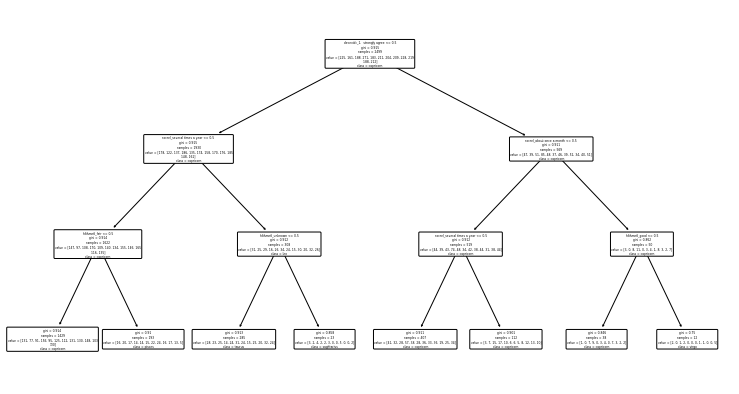

In [13]:
#plotting decision tree
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, rounded=True)

In [14]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]


array(['taurus', 'capricorn', 'capricorn', 'capricorn', 'capricorn'],
      dtype=object)

In [15]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]


array([[0.09824561, 0.08070175, 0.0877193 , 0.04912281, 0.08421053,
        0.10877193, 0.08421053, 0.05263158, 0.0877193 , 0.07017544,
        0.1122807 , 0.08421053],
       [0.1007371 , 0.07862408, 0.06879607, 0.14004914, 0.09336609,
        0.06879607, 0.08845209, 0.08108108, 0.08845209, 0.04668305,
        0.06142506, 0.08353808],
       [0.0916725 , 0.05388383, 0.0636809 , 0.10916725, 0.06648006,
        0.08747376, 0.07837649, 0.0916725 , 0.09097271, 0.10356893,
        0.07207838, 0.09097271],
       [0.0916725 , 0.05388383, 0.0636809 , 0.10916725, 0.06648006,
        0.08747376, 0.07837649, 0.0916725 , 0.09097271, 0.10356893,
        0.07207838, 0.09097271],
       [0.0916725 , 0.05388383, 0.0636809 , 0.10916725, 0.06648006,
        0.08747376, 0.07837649, 0.0916725 , 0.09097271, 0.10356893,
        0.07207838, 0.09097271]])

In [16]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.12


## Classification Report of Decision Tree Model:

In [17]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

    aquarius       0.00      0.00      0.00       225
       aries       0.00      0.00      0.00       161
      cancer       0.00      0.00      0.00       188
   capricorn       0.12      0.88      0.21       271
      gemini       0.00      0.00      0.00       183
         leo       0.00      0.00      0.00       211
       libra       0.00      0.00      0.00       204
      pisces       0.12      0.11      0.12       209
 sagittarius       0.22      0.02      0.04       228
     scorpio       0.00      0.00      0.00       219
      taurus       0.11      0.17      0.14       188
       virgo       0.42      0.02      0.04       212

    accuracy                           0.12      2499
   macro avg       0.08      0.10      0.05      2499
weighted avg       0.09      0.12      0.05      2499



## Takeaways:
The Classification Report of the Decision Tree model is showing very low predictor accuracy scores.
> Key Takeaways from report:
- Precision score: Low numbers show that there were alot of false positives.
- F1 score: really not close to 1.0 to show that this model is worth pursuing. 

In [18]:
#using validation dataset to see if accuracy score changes...
y_validate.head()

2867    sagittarius
2815         pisces
2340         pisces
1964        scorpio
436       capricorn
Name: zodiac, dtype: object

In [19]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.09


In [20]:
# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))


              precision    recall  f1-score   support

    aquarius       0.00      0.00      0.00        61
       aries       0.00      0.00      0.00        40
      cancer       0.00      0.00      0.00        37
   capricorn       0.10      0.80      0.18        61
      gemini       0.00      0.00      0.00        36
         leo       0.00      0.00      0.00        49
       libra       0.00      0.00      0.00        61
      pisces       0.06      0.08      0.07        36
 sagittarius       0.00      0.00      0.00        61
     scorpio       0.00      0.00      0.00        67
      taurus       0.05      0.08      0.06        48
       virgo       0.00      0.00      0.00        68

    accuracy                           0.09       625
   macro avg       0.02      0.08      0.03       625
weighted avg       0.02      0.09      0.03       625



### Really not great accuracy scores of prediction. 

__________________________________________________

## Training the Model: Random Forest

Creating fresh splits and X & y datasets:

In [21]:
# create X & y version of train, where y is a series with just the target variable and X are all the driver features. 
train, validate, test = wrangle.split(df)

#get_dummies for driver columns:
dummy_rf = pd.get_dummies(train[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
train = pd.concat([train, dummy_rf], axis=1)

dummy_rf2 = pd.get_dummies(validate[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False)
validate = pd.concat([validate, dummy_rf2], axis=1)

dummy_rf3 = pd.get_dummies(test[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
test = pd.concat([test, dummy_rf3], axis=1)

X_train2 = train.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5','workhard_fifth'])
y_train2 = train.zodiac

X_validate2 = validate.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5'])
y_validate2 = validate.zodiac

X_test2 = test.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5','workhard_fifth'])
y_test2 = test.zodiac

Train: 2499 rows, 66 cols
Validate: 625 rows, 66 cols
Test: 552 rows, 66 cols


In [22]:
#creating the Random Forest classifier
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [23]:
#fitting the RF model to dataset:
rf.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [24]:
#evaluating the importance of each feature of df:
print(rf.feature_importances_)

[0.07116764 0.04920672 0.03867475 0.03383198 0.03240704 0.03401353
 0.08400456 0.03274989 0.02430548 0.03355474 0.02605857 0.03859852
 0.01801092 0.02318412 0.02223273 0.01873657 0.05995164 0.0728812
 0.04065375 0.09209262 0.04498138 0.03015394 0.02761773 0.00773629
 0.04319368]


In [25]:
#Making predictions
y_pred = rf.predict(X_train2)

In [26]:
#creating estimated probability of zodiac prediction model:
y_pred_proba = rf.predict_proba(X_train2)

#### Evaluating RF model:

In [27]:
#Evaluating the model:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train2, y_train2)))


Accuracy of random forest classifier on training set: 0.14


#### Classification Report:

In [28]:
print(classification_report(y_train2, y_pred))

              precision    recall  f1-score   support

    aquarius       0.33      0.07      0.12       225
       aries       0.00      0.00      0.00       161
      cancer       0.30      0.03      0.06       188
   capricorn       0.12      0.89      0.22       271
      gemini       0.00      0.00      0.00       183
         leo       0.12      0.02      0.04       211
       libra       0.17      0.06      0.09       204
      pisces       0.26      0.09      0.13       209
 sagittarius       0.15      0.08      0.11       228
     scorpio       0.27      0.10      0.15       219
      taurus       0.27      0.02      0.04       188
       virgo       0.13      0.05      0.07       212

    accuracy                           0.14      2499
   macro avg       0.18      0.12      0.08      2499
weighted avg       0.18      0.14      0.09      2499



### Takeaways:
- This model performs much better than the Decision Tree model, however precision and f1 scores are still really low.

#### Validating RF model:

In [29]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate2, y_validate2)))

Accuracy of random forest classifier on test set: 0.11


### Not great but still better than baseline and decision tree model.

__________________________________________________________________

## Training the Model: KNNeighbors w/ 3n_neighbors

Creating fresh splits and X & y datasets:

In [30]:
# create X & y version of train, where y is a series with just the target variable and X are all the driver features. 
train, validate, test = wrangle.split(df)

#get_dummies for driver columns:
dummy_knn = pd.get_dummies(train[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
train = pd.concat([train, dummy_knn], axis=1)

dummy_knn1 = pd.get_dummies(validate[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False)
validate = pd.concat([validate, dummy_knn1], axis=1)

dummy_knn2 = pd.get_dummies(test[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
test = pd.concat([test, dummy_knn2], axis=1)

X_train3 = train.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5','workhard_fifth'])
y_train3 = train.zodiac

X_validate3 = validate.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5'])
y_validate3 = validate.zodiac

X_test3 = test.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5','workhard_fifth'])
y_test3 = test.zodiac

Train: 2499 rows, 66 cols
Validate: 625 rows, 66 cols
Test: 552 rows, 66 cols


#### Creating KNN model:

In [31]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

#### Fitting model:

In [32]:
knn.fit(X_train3, y_train3)

KNeighborsClassifier()

#### Making predictions & estimating probability:

In [34]:
y_pred = knn.predict(X_train3)
y_pred_proba = knn.predict_proba(X_train3)


#### Evaluating Model:

In [35]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train3, y_train3)))

Accuracy of KNN classifier on training set: 0.25


#### Classification Report:

In [36]:
print(classification_report(y_train3, y_pred))


              precision    recall  f1-score   support

    aquarius       0.20      0.55      0.29       225
       aries       0.16      0.42      0.23       161
      cancer       0.24      0.32      0.28       188
   capricorn       0.29      0.36      0.32       271
      gemini       0.25      0.22      0.24       183
         leo       0.31      0.18      0.23       211
       libra       0.30      0.18      0.22       204
      pisces       0.33      0.12      0.18       209
 sagittarius       0.32      0.14      0.20       228
     scorpio       0.38      0.21      0.27       219
      taurus       0.39      0.11      0.17       188
       virgo       0.34      0.15      0.21       212

    accuracy                           0.25      2499
   macro avg       0.29      0.25      0.24      2499
weighted avg       0.30      0.25      0.24      2499



#### Validating model to check accuracy there:

In [37]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate3, y_validate3)))


Accuracy of KNN classifier on test set: 0.07


## Takeaway:
- With the low validation score, it looks like despite the higher KNN initial training of the model, this might not be the best choice.

________________________________________________________

## Training the Model: KNNeighbors w/ 10n_neighbors

Creating fresh splits and X & y datasets:

In [43]:
# create X & y version of train, where y is a series with just the target variable and X are all the driver features. 
train, validate, test = wrangle.split(df)

#get_dummies for driver columns:
dummy_k1 = pd.get_dummies(train[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
train = pd.concat([train, dummy_k1], axis=1)

dummy_k12 = pd.get_dummies(validate[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False)
validate = pd.concat([validate, dummy_k12], axis=1)

dummy_k13 = pd.get_dummies(test[['workhard','hlthmntl','socrel','decevidc']], dummy_na=False, drop_first= False, dtype=int)
test = pd.concat([test, dummy_k13], axis=1)

X_train4 = train.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5','workhard_fifth'])
y_train4 = train.zodiac

X_validate4 = validate.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5'])
y_validate4 = validate.zodiac

X_test4 = test.drop(columns=['zodiac', 'race', 'age', 'sex', 'sexornt', 'marital', 'res16', 'reg16',
       'degree', 'income', 'wrkslf', 'satjob', 'occ10', 'partyid', 'if16who',
       'polviews', 'gunlaw', 'grassv', 'relig', 'postlifev', 'postlifenv',
       'sprtprsn', 'sprtconnct', 'sprtlrgr', 'sprtpurp', 'happy', 'life',
       'obey', 'popular', 'thnkself', 'workhard', 'helpoth', 'grtwrks',
       'freemind', 'decevidc', 'advfmsci', 'mditate1', 'health', 'hlthphys',
       'hlthmntl', 'enjoynat', 'eatmeat', 'recycle', 'nobuygrn', 'fairv',
       'fairnv', 'helpfulv', 'helpfulnv', 'trustv', 'trustnv', 'conmedic',
       'contv', 'conpress', 'consci', 'conjudge', 'conlegis', 'socbar',
       'socrel', 'socommun', 'socfrend', 'satsoc', 'class', 'satfin',
       'quallife', 'partners', 'partnrs5','workhard_fifth'])
y_test4 = test.zodiac

Train: 2499 rows, 66 cols
Validate: 625 rows, 66 cols
Test: 552 rows, 66 cols


In [44]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')

#Fitting model:
knn.fit(X_train4, y_train4)

#Making predictions & estimating probability:
y_pred = knn.predict(X_train4)
y_pred_proba = knn.predict_proba(X_train4)


In [45]:
#Evaluating Model:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train4, y_train4)))


Accuracy of KNN classifier on training set: 0.23


#### Classification Report:

In [46]:

print(classification_report(y_train4, y_pred))


              precision    recall  f1-score   support

    aquarius       0.19      0.38      0.26       225
       aries       0.24      0.29      0.26       161
      cancer       0.22      0.32      0.26       188
   capricorn       0.25      0.43      0.31       271
      gemini       0.17      0.14      0.15       183
         leo       0.26      0.22      0.24       211
       libra       0.28      0.19      0.23       204
      pisces       0.20      0.21      0.21       209
 sagittarius       0.28      0.11      0.16       228
     scorpio       0.32      0.20      0.24       219
      taurus       0.31      0.14      0.20       188
       virgo       0.22      0.13      0.17       212

    accuracy                           0.23      2499
   macro avg       0.25      0.23      0.22      2499
weighted avg       0.25      0.23      0.23      2499



#### Validation of KNN10:

In [47]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate4, y_validate3)))


Accuracy of KNN classifier on test set: 0.09


__________________________________________________________